# Use social sentiment to predict stock price

In [1]:
import pandas as pd
import datetime
import preprocessing

# load pre-processsed data see preprocessing.py for details
# features are already scaled during preprocessing.
X_train, y_train, X_test, y_test, train_dt, test_dt = preprocessing.run_preprocessor(type = "training", 
                                                                                     tweets_file = 'tweets_2020-07-15_2020-07-27.csv', 
                                                                                     stocks_file = 'JETS_2020-07-15_2020-07-27.csv')

## Correlation

                 verified  followers_count  tweet_count  has_locations  \
verified         1.000000         0.465578    -0.260974      -0.014881   
followers_count  0.465578         1.000000    -0.171453       0.027642   
tweet_count     -0.260974        -0.171453     1.000000      -0.137574   
has_locations   -0.014881         0.027642    -0.137574       1.000000   
last_close      -0.043338        -0.045281    -0.044522      -0.011404   
last_vol         0.009528        -0.077549    -0.038715      -0.065387   
last_pct_change -0.107496         0.104267    -0.099368       0.020965   
target          -0.022077        -0.065600    -0.024973      -0.015357   

                 last_close  last_vol  last_pct_change    target  
verified          -0.043338  0.009528        -0.107496 -0.022077  
followers_count   -0.045281 -0.077549         0.104267 -0.065600  
tweet_count       -0.044522 -0.038715        -0.099368 -0.024973  
has_locations     -0.011404 -0.065387         0.020965 -0.015357 

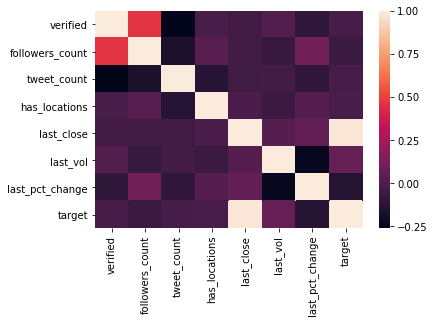

In [2]:
features = pd.read_csv('./data/tmp/features.csv', parse_dates = ['datetime'])
# import pandas.rpy.common as com
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix
corr = features.corr()
print(corr)
# plot the heatmap
sns.heatmap(corr)

In [3]:
features.head()

,datetime,verified,followers_count,tweet_count,has_locations,last_close,last_vol,last_pct_change,target
0,2020-07-15 15:15:00,0.055556,16465.277778,18,0.666667,17.1100,402498.0,-0.003494,17.1700
1,2020-07-15 15:30:00,0.032609,7134.260870,92,0.869565,17.1700,213804.0,-0.004638,17.2500
2,2020-07-15 15:45:00,0.013889,8031.194444,72,0.902778,17.2500,302492.0,0.001736,17.2201
3,2020-07-15 16:00:00,0.000000,4301.067164,134,0.805970,17.2201,298626.0,-0.001154,17.2400
4,2020-07-16 13:45:00,0.133333,38307.933333,15,0.800000,16.7500,54801.0,0.002994,16.7000


# Try models

In [4]:
seedn = 1234
import numpy as np
import datetime
import pandas as pd 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook

import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
import logging

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost

# neural nets
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

Using TensorFlow backend.


### Evaluation Metrics

In [5]:
from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates
register_matplotlib_converters()
def fit_and_score(model, te_pred, X_tr, y_tr, X_te, y_te, test_datetime, plot=True):
    if model is None:
        if te_pred is not None:
            print(f'Test MAE: {mean_absolute_error(y_te, te_pred)}')
        else:
            raise ValueError('te_pred is None. Provide test prediction value!')
    else:
        cv_score = cross_validate(model, X_tr, y_tr, scoring = 'neg_mean_absolute_error', cv = 3, return_train_score = True)
        print('Cross-Validation Scores:')
        print("Train MAE: {m} +/- {sd}".format(m = round(-np.mean(cv_score['train_score']),5), sd = round(np.std(cv_score['train_score']),4)))
        print("Eval MAE: {m} +/- {sd}".format(m = round(-np.mean(cv_score['test_score']),5), sd = round(np.std(cv_score['test_score']),4)))
        model.fit(X_tr, y_tr)
        print(f'- '*15)
        te_pred = model.predict(X_te)
        print(f'Test MAE: {mean_absolute_error(y_te, te_pred)}')
        
    if plot:
        ax = plt.gca()
        formatter = mdates.DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(formatter)
        locator = mdates.HourLocator()
        ax.xaxis.set_major_locator(locator)
        dt = pd.to_datetime(test_datetime)
        plt.title(f'{type(model).__name__}')
        plt.plot(test_datetime,y_te)
        plt.plot(test_datetime,te_pred)
        plt.legend(['actual','prediction'])
        plt.show()

## Model 1: guess mean of last 4 prices

(193, 17) (193,)
(173, 17) (20, 17) (173,) (20,)
Test MAE: 0.03703124999999989


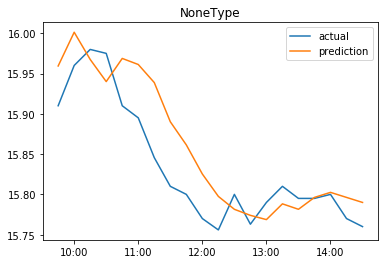

In [6]:
def add_timesteps(df, n):
    '''function adds n number of past time step stocks data to the dataset
    input: dataframe of features, n: number of past time step stocks data 
    user wishes to include in the feature vector
    output: dataframe with additional past stocks data'''
    for i in range(n-1):
        origdf = df.copy()
        tmp = origdf[['last_close','last_vol','last_pct_change']].shift(i+1).\
        rename(columns={'last_close':f'last_close_t-{i+2}',
                        'last_vol':f'last_vol_t-{i+2}',
                        'last_pct_change':f'last_pct_change_t-{i+2}'})
        df = pd.concat([df,tmp], axis=1)
    return df
df = features.iloc[:,:-1]
price = features.iloc[:,-1]

df = add_timesteps(df, 4) # add t-2, t-3, t-4 data
df = df.dropna() # drop NaN due to shifting data to achieve past n timesteps
y = price.iloc[3:] # drop corresponding prices where feature vector contains NaN
print(df.shape, y.shape)

x_tr = df.iloc[:-20,]
x_te = df.iloc[-20:,]
y_tr = y.iloc[:-20,]
y_te = y.iloc[-20:,]
print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
# reshape y

guess_last4mean = x_te.apply(lambda x: (x['last_close']+x['last_close_t-2']+x['last_close_t-3']+x['last_close_t-3'])/4, axis = 1)

# Evaluate basic model
estimator = None
fit_and_score(estimator, guess_last4mean, x_tr, y_tr, x_te, y_te, test_dt)

## Model 2. Random Forest

Cross-Validation Scores:
Train MAE: 0.01562 +/- 0.0015
Eval MAE: 0.08152 +/- 0.0336
- - - - - - - - - - - - - - - 
Test MAE: 0.09600401935594842


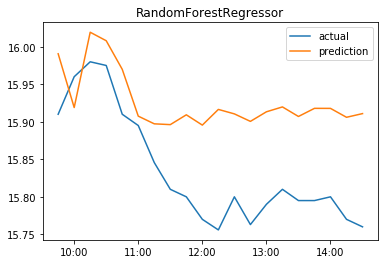

In [7]:
rfr = RandomForestRegressor(random_state=seedn, max_depth = 5, n_estimators = 100)
fit_and_score(rfr, None, X_train, y_train, X_test, y_test, test_dt)

## Model 3: KNN

Cross-Validation Scores:
Train MAE: 0.04983 +/- 0.0076
Eval MAE: 0.13361 +/- 0.0535
- - - - - - - - - - - - - - - 
Test MAE: 0.14787000000000008


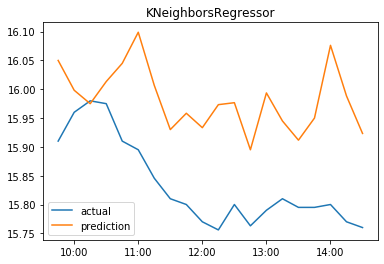

In [8]:
knn = KNeighborsRegressor(3)
sc = MinMaxScaler(feature_range=(0,1))
fit_and_score(knn, None, X_train, y_train, X_test, y_test, test_dt)

# Neural Nets

## LSTM

Use 4 time steps

In [9]:
train = features.iloc[:176,1:]
test = features.iloc[176:,1:]
sc = MinMaxScaler(feature_range=(0,1))
x_train = sc.fit_transform(train) # except Datetime column
x_test = sc.transform(test) # except Datetime column
print(x_train.shape)
print(x_test.shape)

(176, 8)
(20, 8)


In [10]:
params = {
    "batch_size": 5,  # 20<16<10, 25 was a bust
    "epochs": 500,
    "lr": 0.050000,
    "time_steps": 4
}

iter_changes = "dropout_layers_0.4_0.4"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params['batch_size']

def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

def build_timeseries(mat, y_col_index):
    """
    https://github.com/nayash/Stock-Price-Prediction/blob/master/stock_pred_main.py
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 7)
print("Train size",x_t.shape, y_t.shape)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)
# append last 4 timesteps from training set to test set.
last4tr = x_train[-4:,:]
x_test = np.append(last4tr, x_test, axis=0)
x_test_t, y_test_t = build_timeseries(x_test, 7)
print("Test size", x_test_t.shape, y_test_t.shape)
x_test_t = trim_dataset(x_test_t, BATCH_SIZE)
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
print("Batch trimmed size",x_test_t.shape, y_test_t.shape)

Are any NaNs present in train/test matrices? False False
dim_0 172



length of time-series i/o (172, 4, 8) (172,)
Train size (172, 4, 8) (172,)
Batch trimmed size (170, 4, 8) (170,)
dim_0 20



length of time-series i/o (20, 4, 8) (20,)
Test size (20, 4, 8) (20,)
Batch trimmed size (20, 4, 8) (20,)


In [13]:
from matplotlib import pyplot as plt
def plot_model_loss(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [15]:
def lstm_model():
    model = Sequential()

    model.add(LSTM(units=50,return_sequences=True,input_shape=(TIME_STEPS, x_t.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(LSTM(units=50))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=1))

    adam = optimizers.Adam(learning_rate = params['lr'])
    model.compile(optimizer=adam,loss='mean_squared_error')
    return model

lstm = lstm_model()
es = EarlyStopping(monitor='val_loss', mode='min', patience=7)
cp = ModelCheckpoint(filepath='./models/model.{epoch:02d}-{val_loss:.2f}.h5')
my_callbacks = [es,cp]
history = lstm.fit(x_t,y_t,epochs=params['epochs'],batch_size=params['batch_size'], 
                    validation_split=0.2, callbacks=my_callbacks)

Test MAE: 0.5384848988342285


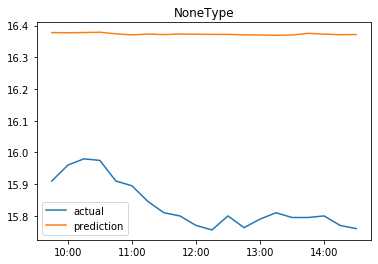

In [13]:
y_pred = lstm.predict(x_test_t)
# convert the predicted value to range of real data
y_pred_org = (y_pred * sc.data_range_[7]) + sc.data_min_[7]
y_te = test.iloc[:,-1]
estimator = None
fit_and_score(estimator, y_pred_org,x_train, y_train, x_test, y_test, test_dt)

## FFNN

In [10]:
def ffnn(num_layers, neurons):
    '''build ffnn
    input: 
    num_layers, integer, 
    neurons, list of integers
    output:
    modl'''
    model = Sequential()
    for l in range(num_layers):
        model.add(Dense(neurons[l]))
    model.add(Dense(1))
    adam = optimizers.Adam(learning_rate = params['lr'])
    model.compile(optimizer=adam,loss='mean_squared_error')

    return model

(176, 7)
(20, 7)
Train on 140 samples, validate on 36 samples
Epoch 1/500
140/140 [==============================] - 1s 4ms/step - loss: 40.2434 - val_loss: 5.1178

Epoch 00001: val_loss improved from inf to 5.11777, saving model to ./models/checkpoints/ffnn50.01-5.12.h5
Epoch 2/500
140/140 [==============================] - 0s 321us/step - loss: 3.4490 - val_loss: 1.7618

Epoch 00002: val_loss improved from 5.11777 to 1.76178, saving model to ./models/checkpoints/ffnn50.02-1.76.h5
Epoch 3/500
140/140 [==============================] - 0s 324us/step - loss: 1.9006 - val_loss: 1.3042

Epoch 00003: val_loss improved from 1.76178 to 1.30419, saving model to ./models/checkpoints/ffnn50.03-1.30.h5
Epoch 4/500
140/140 [==============================] - 0s 343us/step - loss: 1.6340 - val_loss: 1.1151

Epoch 00004: val_loss improved from 1.30419 to 1.11511, saving model to ./models/checkpoints/ffnn50.04-1.12.h5
Epoch 5/500
140/140 [==============================] - 0s 354us/step - loss: 1.3351

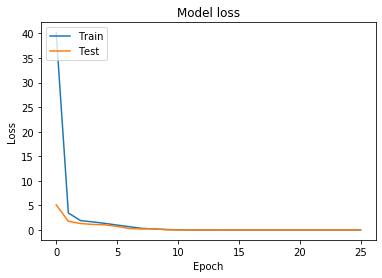

In [16]:
iter_changes = "dropout_layers_0.4_0.4"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params['batch_size']


ffnn50 = ffnn(1,[50])
es = EarlyStopping(monitor='val_loss', mode='min', patience=7)
cp = ModelCheckpoint(filepath='./models/checkpoints/ffnn50.{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss', \
    verbose=1,save_best_only=True, save_weights_only=False, mode='min')
my_callbacks = [es,cp]

print(X_train.shape)
print(X_test.shape)
history = ffnn50.fit(X_train,y_train.values,epochs=params['epochs'],batch_size=params['batch_size'], 
                        validation_split=0.2, callbacks=my_callbacks)
plot_model_loss(history, 'ffnn50_test_accuracy.png')

In [18]:
print("saving model...")
import pickle
pickle.dump(ffnn50, open("./models/ffnn50", "wb"))

saving model...


Test MAE: 0.0009964263153076302


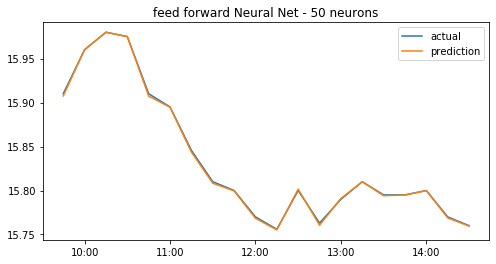

In [23]:
y_pred = ffnn50.predict(X_test)
estimator = None
fit_and_score(estimator, y_pred, X_train, y_train, X_test, y_test, test_dt)